In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import pandas as pd
import torch.optim as optim
import math
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
from scipy.stats import norm
from torchvision import datasets, transforms, utils

# Data

In [2]:
train_set_raw = datasets.MNIST(
    root = '../../../data/MNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
)
test_set_raw = datasets.MNIST(
    root = '../../../data/MNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
)
train_set = list(filter(lambda i: i[1] == 3 or i[1]==8 , train_set_raw))
test_set = list(filter(lambda i: i[1] == 3 or i[1]==8 , test_set_raw))

In [3]:
for i in range(len(train_set)): 
    if train_set[i][1]==3:
        lst=list(train_set[i])
        lst.append(0)
        lst.pop(1)
        train_set[i] = tuple(lst)

    elif train_set[i][1]==8:
        lst=list(train_set[i])
        lst.append(1)
        lst.pop(1)
        train_set[i] = tuple(lst)
    
    else :
        pass
        

In [4]:
train_loader = DataLoader(train_set, batch_size=32,shuffle=True)
test_loader = DataLoader(test_set, batch_size=32,shuffle=True)

# HyperParameter

In [5]:
lr = 0.001
EPOCHS = 40
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

# Feature Selector

In [6]:
actor_h_dim = 200

In [7]:
class Selector(nn.Module):
    def __init__(self):
        super(Selector, self).__init__()

        self.actor_model = nn.Sequential(
            nn.Linear(784, actor_h_dim),
            nn.ReLU(),
            nn.Linear(actor_h_dim, actor_h_dim),
            nn.ReLU(),
            nn.Linear(actor_h_dim, actor_h_dim),
            nn.ReLU(),
            nn.Linear(actor_h_dim, actor_h_dim),
            nn.ReLU(),
            nn.Linear(actor_h_dim, 784),
        )

    def forward(self, x):
        prob = self.actor_model(x)

        return prob

In [8]:
selector = Selector()

In [9]:
class FeatureSelector(nn.Module):
    def __init__(self, input_dim=784):
        super(FeatureSelector, self).__init__()
        self.mu = 0.01*torch.randn(input_dim, )
        self.eps = torch.randn(self.mu.size()) # random noise
        self.sigma = 1.0
    
    def hard_sigmoid(self, x):
        return torch.clamp(x, 0.0, 1.0)

    def forward(self, prev_x):
        self.mu = selector(prev_x)
        z = self.mu + self.sigma*self.eps.normal_()
        stochastic_gate = self.hard_sigmoid(z)
        new_x = prev_x * stochastic_gate
        return new_x
    
    def regularizer(self): # Gaussian CDF
        return 0.5 * (1 + torch.erf(self.mu / math.sqrt(2))) 

    def get_gates(self):
        return self.mu.detach().cpu().numpy(), np.minimum(1.0, np.maximum(0.0, self.mu.detach().cpu().numpy())) 


# Model

In [10]:
feature_selector = FeatureSelector()

In [11]:
class NET(nn.Module):
    def __init__(self):
        super().__init__()
        self.NN =nn.Sequential(
            nn.Linear(784,256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,2),
            nn.Sigmoid()
        )
        self.feature_selector = feature_selector
        self.regularizer = feature_selector.regularizer
        self.get_gates = feature_selector.get_gates
        
    def forward(self,x):
        x = x.view(-1,784)
        x = feature_selector(x)
        x = self.NN(x)
        return x

In [12]:
model = NET()
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [13]:
def train(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0 
   
    for data, target in train_loader:
        input_x, target_x = data, target

        optimizer.zero_grad()
        output = model(input_x)
        regularizer = torch.mean(model.regularizer())
        loss = criterion(output,target_x) + 0.3 * regularizer 
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    return train_loss

In [14]:
result_list = []
for epoch in range(0, EPOCHS + 1):
    train_loss = train(model, train_loader, optimizer, criterion)
    #val_loss = evaluate(model, test_loader,criterion)
    print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}")
    result = {
        'EPOCH': epoch,
        'Train Loss': train_loss,
        #'Val Loss': val_loss,
        #'Val Accuracy': val_accuracy
        }
    result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 0], 	Train Loss: 0.5541
[EPOCH: 1], 	Train Loss: 0.5298
[EPOCH: 2], 	Train Loss: 0.5171
[EPOCH: 3], 	Train Loss: 0.5116
[EPOCH: 4], 	Train Loss: 0.5037
[EPOCH: 5], 	Train Loss: 0.4990
[EPOCH: 6], 	Train Loss: 0.4978
[EPOCH: 7], 	Train Loss: 0.4986
[EPOCH: 8], 	Train Loss: 0.4954
[EPOCH: 9], 	Train Loss: 0.4938
[EPOCH: 10], 	Train Loss: 0.4921
[EPOCH: 11], 	Train Loss: 0.4924
[EPOCH: 12], 	Train Loss: 0.4915
[EPOCH: 13], 	Train Loss: 0.4910
[EPOCH: 14], 	Train Loss: 0.4894
[EPOCH: 15], 	Train Loss: 0.4902
[EPOCH: 16], 	Train Loss: 0.4872
[EPOCH: 17], 	Train Loss: 0.4877
[EPOCH: 18], 	Train Loss: 0.4909
[EPOCH: 19], 	Train Loss: 0.4878
[EPOCH: 20], 	Train Loss: 0.4875
[EPOCH: 21], 	Train Loss: 0.4843
[EPOCH: 22], 	Train Loss: 0.4856
[EPOCH: 23], 	Train Loss: 0.4859
[EPOCH: 24], 	Train Loss: 0.4866
[EPOCH: 25], 	Train Loss: 0.4875
[EPOCH: 26], 	Train Loss: 0.4848
[EPOCH: 27], 	Train Loss: 0.4837
[EPOCH: 28], 	Train Loss: 0.4841
[EPOCH: 29], 	Train Loss: 0.4838
[EPOCH: 30], 	Train 

<AxesSubplot:>

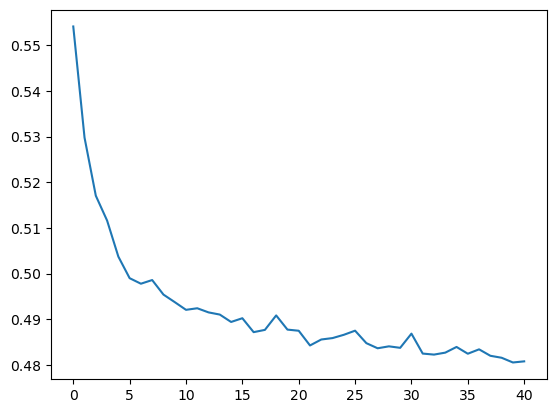

In [15]:
result_df['Train Loss'].plot()

In [16]:
raw, prob = model.get_gates()
#print('raw : ', raw)
print(" prob : ", prob)

 prob :  [[0.09046578 0.06778814 0.00383873 ... 0.         0.07506263 0.03186372]
 [0.09443724 0.06488867 0.00462349 ... 0.         0.07241939 0.03180945]
 [0.09209282 0.05936721 0.00643781 ... 0.         0.07551174 0.03535706]
 ...
 [0.09123566 0.06728856 0.00458806 ... 0.         0.07437897 0.03195434]
 [0.09527514 0.06472076 0.00378748 ... 0.         0.07516748 0.03857888]
 [0.09467068 0.0615145  0.00165498 ... 0.         0.07994742 0.03712402]]


In [22]:
prob

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [17]:
prob.shape

(14, 784)

(-0.5, 27.5, 27.5, -0.5)

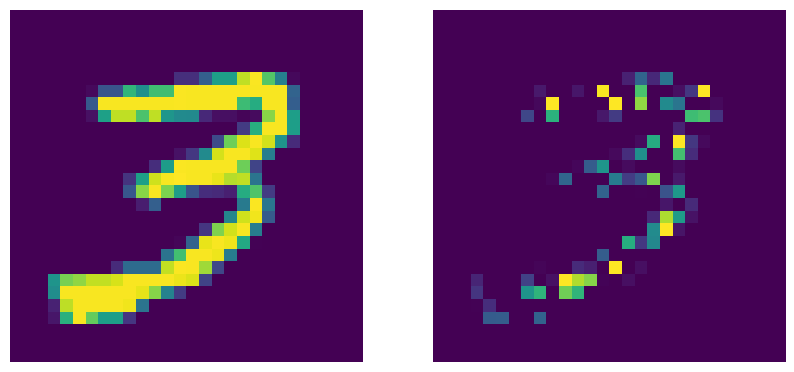

In [19]:
test = train_set[100]
lst = list(test)
test = lst[0][0]

feature_selector.eval()
test = test.reshape(784)
prob = feature_selector(test)
test_prob = prob.reshape(28,28)
test = test.reshape(28,28)
final = test * test_prob
final = final.detach().numpy()

fig =  plt.figure(figsize=(10,20))
rows = 1 
cols = 2

ax1 = fig.add_subplot(rows,cols,1)
ax1.imshow(test)
ax1.axis('off')

ax2= fig.add_subplot(rows,cols,2)
ax2.imshow(final)
ax2.axis('off')

(-0.5, 27.5, 27.5, -0.5)

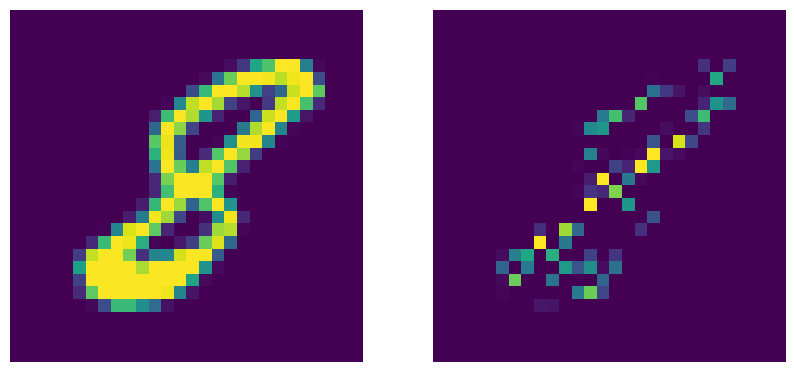

In [20]:
test = train_set[101]
lst = list(test)
test = lst[0][0]

feature_selector.eval()
test = test.reshape(784)
prob = feature_selector(test)
test_prob = prob.reshape(28,28)
test = test.reshape(28,28)
final = test * test_prob
final = final.detach().numpy()

fig =  plt.figure(figsize=(10,20))
rows = 1 
cols = 2

ax1 = fig.add_subplot(rows,cols,1)
ax1.imshow(test)
ax1.axis('off')

ax2= fig.add_subplot(rows,cols,2)
ax2.imshow(final)
ax2.axis('off')

(-0.5, 27.5, 27.5, -0.5)

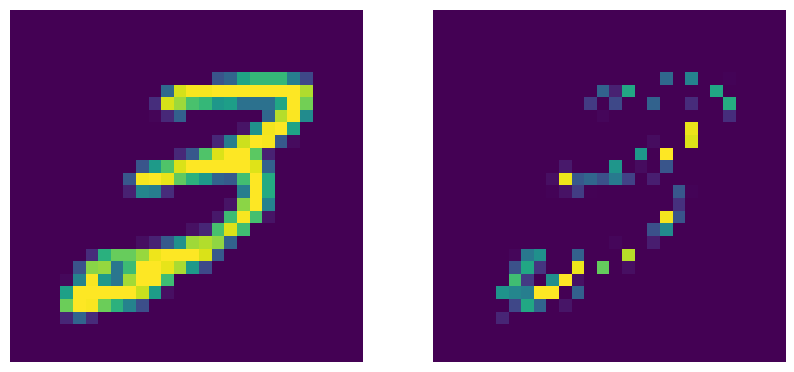

In [21]:
test = train_set[102]
lst = list(test)
test = lst[0][0]

feature_selector.eval()
test = test.reshape(784)
prob = feature_selector(test)
test_prob = prob.reshape(28,28)
test = test.reshape(28,28)
final = test * test_prob
final = final.detach().numpy()

fig =  plt.figure(figsize=(10,20))
rows = 1 
cols = 2

ax1 = fig.add_subplot(rows,cols,1)
ax1.imshow(test)
ax1.axis('off')

ax2= fig.add_subplot(rows,cols,2)
ax2.imshow(final)
ax2.axis('off')